# Step #1 Load the Data

In [29]:
# A tutorial for this file is available at www.relataly.com
# Tested with Python 3.9.13, Matplotlib 3.6.2, Scikit-learn 1.2, Seaborn 0.12.1, numpy 1.21.5, xgboost 1.7.2

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support as score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.utils import compute_sample_weight
import plotly.express as px
from xgboost import XGBClassifier


# load the train data
path = 'C:/Users/Flo/workspace/workspace_relataly/relataly-public-python-tutorials/data/iot/classification/'
df = pd.read_csv(path + "predictive_maintenance.csv") 

# define the target
target_name='Failure Type'

# drop a redundant columns
df.drop(columns=['Target'], inplace=True)

# print a summary of the train data
print(df.shape[0])
df.head(3)

10000


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,No Failure


# Step #2 Clean the Data

In [30]:
# check for missing values
def print_missing_values(df):
    null_df = pd.DataFrame(df.isna().sum(), columns=['null_values']).sort_values(['null_values'], ascending=False)
    fig = plt.subplots(figsize=(16, 6))
    ax = sns.barplot(data=null_df, x='null_values', y=null_df.index, color='royalblue')
    pct_values = [' {:g}'.format(elm) + ' ({:.1%})'.format(elm/len(df)) for elm in list(null_df['null_values'])]
    ax.set_title('Overview of missing values')
    ax.bar_label(container=ax.containers[0], labels=pct_values, size=12)

if df.isna().sum().sum() > 0:
    print_missing_values(df)
else:
    print('no missing values')

# drop all columns with more than 5% missing values
for col_name in df.columns:
    if df[col_name].isna().sum()/df.shape[0] > 0.05:
        df.drop(columns=[col_name], inplace=True) 

df.columns

no missing values


Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Failure Type'],
      dtype='object')

In [31]:
# drop id columns
df_base = df.drop(columns=['Product ID', 'UDI'])

# adjust column names
df_base.rename(columns={'Air temperature [K]': 'air_temperature', 
                        'Process temperature [K]': 'process_temperature', 
                        'Rotational speed [rpm]':'rotational_speed', 
                        'Torque [Nm]': 'torque', 
                        'Tool wear [min]': 'tool_wear'}, inplace=True)
df_base.head()

,Type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,Failure Type
0,M,298.1,308.6,1551,42.8,0,No Failure
1,L,298.2,308.7,1408,46.3,3,No Failure
2,L,298.1,308.5,1498,49.4,5,No Failure
3,L,298.2,308.6,1433,39.5,7,No Failure
4,L,298.2,308.7,1408,40.0,9,No Failure


# Step #3 Explore the Data

In [45]:
# display class distribution of the target variable
px.histogram(df_base, y="Failure Type", color="Failure Type") 

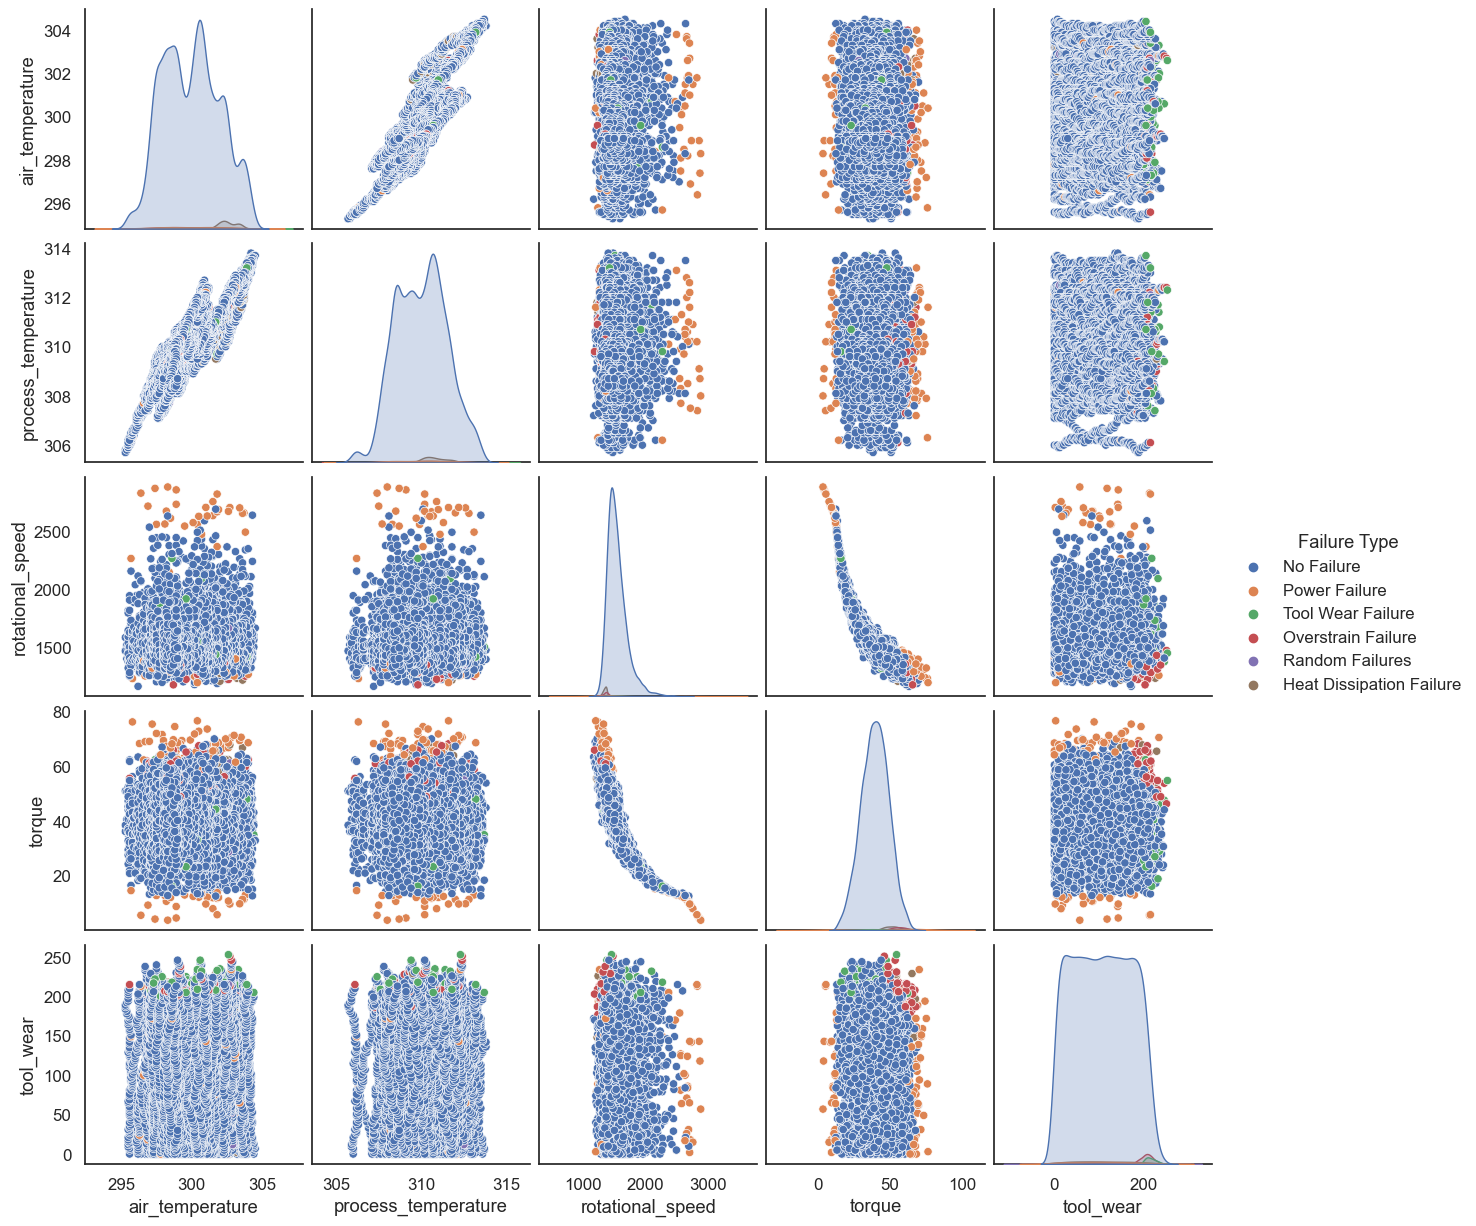

In [33]:
# pairplots on failure type
sns.pairplot(df_base, height=2.5, hue='Failure Type')

<AxesSubplot: >

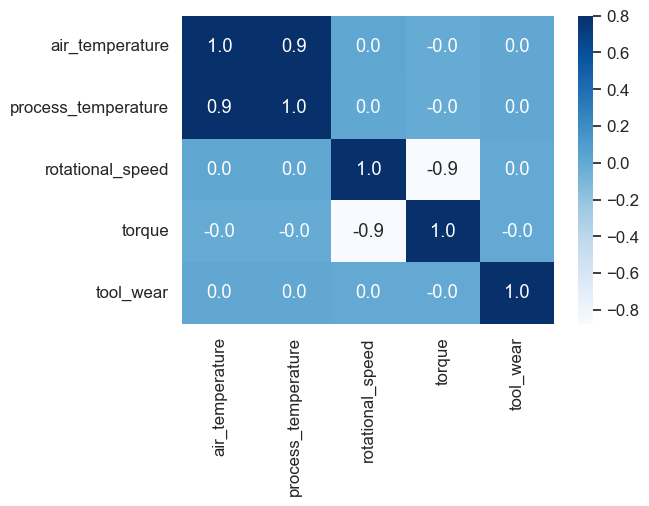

In [34]:
# correlation plot
plt.figure(figsize=(6,4))
sns.heatmap(df_base.corr(), cbar=True, fmt='.1f', vmax=0.8, annot=True, cmap='Blues')

In [35]:
# create histograms for feature columns separated by target column
def create_histogram(column_name):
    plt.figure(figsize=(16,6))
    return px.box(data_frame=df_base, y=column_name, color='Failure Type', points="all", width=1200)

create_histogram('air_temperature')

<Figure size 1600x600 with 0 Axes>

In [36]:
create_histogram('process_temperature')

<Figure size 1600x600 with 0 Axes>

In [37]:
create_histogram('rotational_speed')

<Figure size 1600x600 with 0 Axes>

In [38]:
create_histogram('torque')

<Figure size 1600x600 with 0 Axes>

In [39]:
create_histogram('tool_wear')

<Figure size 1600x600 with 0 Axes>

# Step #3 Data Preparation

In [40]:
def data_preparation(df_base, target_name):
    df = df_base.dropna()

    df['target_name_encoded'] = df[target_name].replace({'No Failure': 0, 'Power Failure': 1, 'Tool Wear Failure': 2, 'Overstrain Failure': 3, 'Random Failures': 4, 'Heat Dissipation Failure': 5})
    df['Type'].replace({'L': 0, 'M': 1, 'H': 2}, inplace=True)
    X = df.drop(columns=[target_name, 'target_name_encoded'])
    y = df['target_name_encoded'] #Prediction label

    # split the data into x_train and y_train data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

    # print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
    print('train: ', X_train.shape, y_train.shape)
    print('test: ', X_test.shape, y_test.shape)
    return X, y, X_train, X_test, y_train, y_test

# remove target from training data
X, y, X_train, X_test, y_train, y_test = data_preparation(df_base, target_name)

train:  (7000, 6) (7000,)
test:  (3000, 6) (3000,)


# Step #4 Model Training

In [41]:
weight_train = compute_sample_weight('balanced', y_train)
weight_test = compute_sample_weight('balanced', y_test)

xgb_clf = XGBClassifier(booster='gbtree', 
                        tree_method='gpu_hist', 
                        sampling_method='gradient_based', 
                        eval_metric='aucpr', 
                        objective='multi:softmax', 
                        num_class=6)
# fit the model to the data
xgb_clf.fit(X_train, y_train.ravel(), sample_weight=weight_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_class=6, num_parallel_tree=1,
              objective='multi:softmax', ...)

# Step #5 Model Evaluation

In [42]:
# score the model with the test dataset
score = xgb_clf.score(X_test, y_test.ravel(), sample_weight=weight_test)

# predict on the test dataset
y_pred = xgb_clf.predict(X_test)

# print a classification report
results_log = classification_report(y_test, y_pred)
print(results_log)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2903
           1       0.64      0.88      0.74        24
           2       0.04      0.08      0.06        12
           3       0.77      0.89      0.83        27
           4       0.00      0.00      0.00         4
           5       0.76      0.97      0.85        30

    accuracy                           0.98      3000
   macro avg       0.53      0.63      0.58      3000
weighted avg       0.98      0.98      0.98      3000



In [43]:
# cross validation
scores  = cross_validate(xgb_clf, X_train, y_train, cv=10, scoring="f1_weighted", fit_params={ "sample_weight" :weight_train})
scores_df = pd.DataFrame(scores)
px.bar(x=scores_df.index, y=scores_df.test_score, width=800)

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

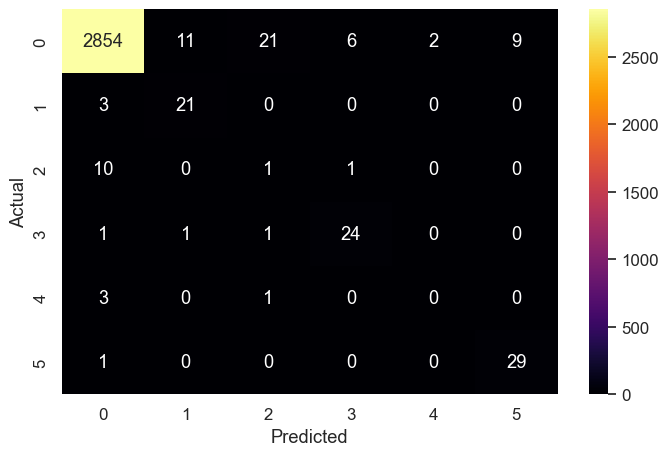

In [44]:
# create predictions on the test dataset
y_pred = xgb_clf.predict(X_test)

# print a multi-Class Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cnf_matrix, columns=np.unique(y_test), index=np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8, 5))
sns.set(font_scale=1.1) #for label size
sns.heatmap(df_cm, cbar=True, cmap= "inferno", annot=True, fmt='.0f') 